In [8]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
from pathlib import Path
from itertools import combinations
import pandas as pd
import networkx as nx
from datetime import datetime, timedelta
# === Đường dẫn thư mục chứa các file parquet === 
base_path = Path(r"D:\recommendation dataset")

# === Tìm tất cả file parquet ===
all_parquet_files = list(base_path.glob("*.parquet"))
print(f"Tìm thấy {len(all_parquet_files)} file parquet trong thư mục.")

# === Phân loại file ===
sales_item_files = []
sales_purchase_files = []
sales_user_files = []

for file_path in all_parquet_files:
    name = file_path.name.lower()
    if "sales_pers.item" in name:
        sales_item_files.append(file_path)
    elif "sales_pers.purchase" in name or "sales_pers.purchase_history_daily" in name:
        sales_purchase_files.append(file_path)
    elif "sales_pers.user" in name:
        sales_user_files.append(file_path)

print(f"""
 Tổng kết:
   sales_pers.item: {len(sales_item_files)} files
   sales_pers.purchase: {len(sales_purchase_files)} files
   sales_pers.user: {len(sales_user_files)} files
""")

# === Đọc tất cả files của mỗi nhóm bằng Polars ===
def read_parquet_group(file_list, group_name):
    if not file_list:
        print(f"Không có file nào cho nhóm {group_name}")
        return None
    
    print(f"Đang đọc {len(file_list)} file(s) cho nhóm {group_name}...")
    
    # Polars cho phép đọc nhiều file cùng lúc chỉ bằng 1 dòng
    df = pl.read_parquet(file_list)
    
    print(f"{group_name} loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df

sales_item_df = read_parquet_group(sales_item_files, "SALES ITEM")
sales_purchase_df = read_parquet_group(sales_purchase_files, "SALES PURCHASE")
sales_user_df = read_parquet_group(sales_user_files, "SALES USER")

# === Tổng kết ===
print("\nTỔNG KẾT DỮ LIỆU:")
if sales_item_df is not None:
    print(f"sales_item_df: {sales_item_df.shape}")
if sales_purchase_df is not None:
    print(f"sales_purchase_df: {sales_purchase_df.shape}")
if sales_user_df is not None:
    print(f"sales_user_df: {sales_user_df.shape}")
    
datasets = {
    "SALES ITEM": sales_item_df,
    "SALES PURCHASE": sales_purchase_df,
    "SALES USER": sales_user_df
}

# Danh sách các cột cần loại bỏ
cols_to_drop = [
    # SALES ITEM
    "is_deleted",
    "last_sync_date",
    "sync_error_message",
    "image_url",
    "description_new",
    "weight",
    "sync_status_id",
    "category_l1_id",
    "category_l2_id",
    "category_l3_id",
    "category_id",
    "manufacturer",

    # SALES PURCHASE
    "is_deleted",
    "event_type",

    # SALES USER
    "is_deleted",
    "sync_status_id",
    "last_sync_date",
    "sync_error_message",
]

# Lặp qua từng DataFrame trong datasets
for name, df in datasets.items():
    if df is None:
        continue

    print(f"\n[ {name} ]")
    existing_cols = [c for c in cols_to_drop if c in df.columns]

    if existing_cols:
        print(f" - Các cột sẽ bị loại bỏ: {existing_cols}")
        df = df.drop(existing_cols)
        datasets[name] = df  # Cập nhật lại DataFrame sau khi loại bỏ
    else:
        print(" - Không có cột nào trong danh sách cần loại bỏ.")

    print(f" - Kích thước mới: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Các cột numeric cần xử lý outlier
target_columns = {
    "SALES ITEM": ['price', 'creation_timestamp', 'gp'],
    "SALES PURCHASE": ['price'],
    "SALES USER": ['timestamp', 'install_date']
}

# Xử lý outlier bằng IQR (Capping)
for group_name, cols in target_columns.items():
    df = datasets.get(group_name)
    if df is None:
        print(f"Không tìm thấy dataset '{group_name}'.")
        continue

    num_cols = [col for col in cols if col in df.columns]
    if not num_cols:
        print(f"[{group_name}] Không có cột numeric hợp lệ để xử lý.")
        continue

    print(f"\n[{group_name}] - Xử lý outlier theo IQR (Capping)")

    df_result = df.clone()

    for col in num_cols:
        try:
            df[col].to_numpy().astype(float)
        except:
            print(f" - Cột '{col}' không phải numeric, bỏ qua.")
            continue

        # Tính IQR và capping
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_iqr, upper_iqr = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

        n_outliers = df.filter((pl.col(col) < lower_iqr) | (pl.col(col) > upper_iqr)).height
        print(f" - {col}: {n_outliers:,} giá trị outlier được capping")

        # Thực hiện capping
        df_result = df_result.with_columns(
            pl.when(pl.col(col) < lower_iqr).then(lower_iqr)
            .when(pl.col(col) > upper_iqr).then(upper_iqr)
            .otherwise(pl.col(col)).alias(col)
        )

    # Cập nhật lại dataset sau khi xử lý
    datasets[group_name] = df_result

print("\nHoàn tất xử lý outlier cho tất cả nhóm.")

# Giới hạn số dòng để tránh MemoryError
max_sample = 100_000

reduced_datasets = {}

for name, df in datasets.items():
    if df is None:
        continue

    # Lấy các cột numeric
    num_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype in pl.NUMERIC_DTYPES]
    if len(num_cols) < 2:
        reduced_datasets[name] = df
        continue

    # Lấy mẫu nếu dataset quá lớn
    df_sample = df.select(num_cols)
    if df_sample.height > max_sample:
        df_sample = df_sample.sample(n=max_sample, seed=42)

    # Tính ma trận tương quan tuyệt đối
    corr_matrix = df_sample.to_pandas().corr().abs()

    # Lấy phần tam giác trên (upper triangle)
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    high_corr_pairs = (
        corr_matrix.where(mask)
        .stack()
        .reset_index()
        .rename(columns={0: "correlation", "level_0": "feature_1", "level_1": "feature_2"})
        .query("correlation > 0.85")
    )

    # Xác định các cột cần loại bỏ
    to_drop = set()
    if not high_corr_pairs.empty:
        for _, row in high_corr_pairs.iterrows():
            f2 = row["feature_2"]
            to_drop.add(f2)

    # Loại bỏ các cột tương quan cao
    reduced_datasets[name] = df.drop(list(to_drop)) if to_drop else df

# Cập nhật datasets sau khi giảm tương quan
datasets.update(reduced_datasets)


Tìm thấy 83 file parquet trong thư mục.

 Tổng kết:
   sales_pers.item: 1 files
   sales_pers.purchase: 72 files
   sales_pers.user: 10 files

Đang đọc 1 file(s) cho nhóm SALES ITEM...
SALES ITEM loaded: 27,332 rows × 34 columns
Đang đọc 72 file(s) cho nhóm SALES PURCHASE...
SALES PURCHASE loaded: 35,729,825 rows × 16 columns
Đang đọc 10 file(s) cho nhóm SALES USER...
SALES USER loaded: 4,573,964 rows × 18 columns

TỔNG KẾT DỮ LIỆU:
sales_item_df: (27332, 34)
sales_purchase_df: (35729825, 16)
sales_user_df: (4573964, 18)

[ SALES ITEM ]
 - Các cột sẽ bị loại bỏ: ['is_deleted', 'last_sync_date', 'sync_error_message', 'image_url', 'description_new', 'weight', 'sync_status_id', 'category_l1_id', 'category_l2_id', 'category_l3_id', 'category_id', 'manufacturer', 'is_deleted', 'is_deleted', 'sync_status_id', 'last_sync_date', 'sync_error_message']
 - Kích thước mới: 27,332 rows × 22 columns

[ SALES PURCHASE ]
 - Các cột sẽ bị loại bỏ: ['is_deleted', 'is_deleted', 'event_type', 'is_deleted'

In [9]:
"""
print("\n=== PHÂN TÍCH CẶP SẢN PHẨM HAY MUA CHUNG ===")
item_col = "item_id"
order_col = "pseudo_order_id"
sample_df = sales_purchase_df.sample(n=min(5_000_000, sales_purchase_df.height), seed=42)
# --- Tạo "đơn hàng giả" (user_id + date_key) ---
sample_df = sample_df.with_columns(
    (pl.col("user_id").cast(pl.Utf8) + "_" + pl.col("date_key").cast(pl.Utf8)).alias(order_col)
)
# --- Gom nhóm sản phẩm theo đơn hàng ---
basket_df = (
    sample_df
    .group_by(order_col)
    .agg(pl.col(item_col).unique().alias("items"))
    .filter(pl.col("items").list.len() > 1)
)
print(f"Tạo {basket_df.height:,} 'đơn hàng' giả để thống kê mua chung...")
# --- Sinh các cặp sản phẩm mua chung ---
cooc_pairs = []
for items in basket_df["items"]:
    for a, b in combinations(sorted(items), 2):
        cooc_pairs.append((a, b))
# --- Tổng hợp và đếm số lần mua chung ---
cooc_df = (
    pl.DataFrame(cooc_pairs, schema=["item_1", "item_2"])
    .group_by(["item_1", "item_2"])
    .agg(pl.count().alias("cooc_count"))
    .sort("cooc_count", descending=True)
)
print(f"Tổng số cặp sản phẩm mua chung: {cooc_df.height:,}")
# --- Ghép thêm thông tin mô tả & danh mục sản phẩm ---
info_cols = [c for c in ["item_id", "category_l1", "category_l2", "category_l3", "category", "description"] if c in sales_item_df.columns]
item_info = sales_item_df.select(info_cols)
# Join để thêm thông tin danh mục & mô tả cho item_1, item_2
cooc_df = (
    cooc_df
    .join(item_info.rename({c: f"item_1_{c}" for c in info_cols if c != "item_id"}).rename({"item_id": "item_1"}), on="item_1", how="left")
    .join(item_info.rename({c: f"item_2_{c}" for c in info_cols if c != "item_id"}).rename({"item_id": "item_2"}), on="item_2", how="left")
)
# --- In Top 20 cặp sản phẩm mua chung kèm thông tin ---
cols_to_show = [
    "item_1", "item_1_category_l1", "item_1_category_l2", "item_1_category_l3",
    "item_1_category", "item_1_description",
    "item_2", "item_2_category_l1", "item_2_category_l2", "item_2_category_l3",
    "item_2_category", "item_2_description",
    "cooc_count"
]
cols_to_show = [c for c in cols_to_show if c in cooc_df.columns]
print("\nTop 20 cặp sản phẩm thường được mua chung nhất (kèm danh mục & mô tả):")
print(cooc_df.select(cols_to_show).head(20))

# --- Lưu kết quả ra CSV ---
output_dir = Path().resolve()
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "product_cooccurrence.csv"
cooc_df.write_csv(output_path)
print(f"\nĐã lưu kết quả thống kê tại: {output_path}")

heat_df = (
    cooc_df
    .select(["item_1_category_l1", "item_2_category_l1", "cooc_count"])
    .group_by(["item_1_category_l1", "item_2_category_l1"])
    .agg(pl.sum("cooc_count").alias("total_cooc"))
    .to_pandas()
)
pivot_df = heat_df.pivot_table(
    index="item_1_category_l1",
    columns="item_2_category_l1",
    values="total_cooc",
    fill_value=0
)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap="YlOrRd", linewidths=0.5)
plt.title("Bản đồ nhiệt: Tần suất mua chung giữa các danh mục cấp 1", fontsize=14)
plt.xlabel("Danh mục 2")
plt.ylabel("Danh mục 1")
plt.tight_layout()
plt.show()

graph_df = (
    cooc_df
    .select(["item_1_category_l1", "item_2_category_l1", "cooc_count"])
    .group_by(["item_1_category_l1", "item_2_category_l1"])
    .agg(pl.sum("cooc_count").alias("total_cooc"))
    .sort("total_cooc", descending=True)
    .head(30)
    .to_pandas()
)

G = nx.Graph()
for _, row in graph_df.iterrows():
    G.add_edge(row["item_1_category_l1"], row["item_2_category_l1"], weight=row["total_cooc"])
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = nx.draw_networkx_edges(G, pos, width=[w['weight']/graph_df["total_cooc"].max()*8 for _,_,w in G.edges(data=True)], alpha=0.6)
nodes = nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=2000)
labels = nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
plt.title("Biểu đồ mạng: Quan hệ mua chung giữa các danh mục cấp 1", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()
"""

'\nprint("\n=== PHÂN TÍCH CẶP SẢN PHẨM HAY MUA CHUNG ===")\nitem_col = "item_id"\norder_col = "pseudo_order_id"\nsample_df = sales_purchase_df.sample(n=min(5_000_000, sales_purchase_df.height), seed=42)\n# --- Tạo "đơn hàng giả" (user_id + date_key) ---\nsample_df = sample_df.with_columns(\n    (pl.col("user_id").cast(pl.Utf8) + "_" + pl.col("date_key").cast(pl.Utf8)).alias(order_col)\n)\n# --- Gom nhóm sản phẩm theo đơn hàng ---\nbasket_df = (\n    sample_df\n    .group_by(order_col)\n    .agg(pl.col(item_col).unique().alias("items"))\n    .filter(pl.col("items").list.len() > 1)\n)\nprint(f"Tạo {basket_df.height:,} \'đơn hàng\' giả để thống kê mua chung...")\n# --- Sinh các cặp sản phẩm mua chung ---\ncooc_pairs = []\nfor items in basket_df["items"]:\n    for a, b in combinations(sorted(items), 2):\n        cooc_pairs.append((a, b))\n# --- Tổng hợp và đếm số lần mua chung ---\ncooc_df = (\n    pl.DataFrame(cooc_pairs, schema=["item_1", "item_2"])\n    .group_by(["item_1", "item_2"])\n

In [10]:
"""
def inspect_table(df, name):
    if df is None:
        print(f"{name} is None\n")
        return
    print(f"--- {name} ---")
    print("Schema:")
    print(df.schema)
    print("\nSample data:")
    print(df.head(5))
    print("\n" + "="*50 + "\n")

inspect_table(sales_item_df, "sales_item_df")
inspect_table(sales_purchase_df, "sales_purchase_df")
inspect_table(sales_user_df, "sales_user_df")
"""


'\ndef inspect_table(df, name):\n    if df is None:\n        print(f"{name} is None\n")\n        return\n    print(f"--- {name} ---")\n    print("Schema:")\n    print(df.schema)\n    print("\nSample data:")\n    print(df.head(5))\n    print("\n" + "="*50 + "\n")\n\ninspect_table(sales_item_df, "sales_item_df")\ninspect_table(sales_purchase_df, "sales_purchase_df")\ninspect_table(sales_user_df, "sales_user_df")\n'

In [11]:
# Đảm bảo created_date là datetime
sales_purchase_df = sales_purchase_df.with_columns(
    pl.col("created_date").cast(pl.Datetime)
)

# Lọc sản phẩm
milk_step1 = sales_item_df.filter(
    pl.col("description").str.to_lowercase().str.contains("step 1")
)
milk_mom = sales_item_df.filter(
    pl.col("description").str.to_lowercase().str.contains("mom")
)
milk_age_0_3m = sales_item_df.filter(
    pl.col("age_group").str.to_lowercase().str.contains("0-3m")
)

# Join với bảng purchase
join_cols = ["item_id"]
purchase_step1 = sales_purchase_df.join(milk_step1, on=join_cols, how="inner")
purchase_mom = sales_purchase_df.join(milk_mom, on=join_cols, how="inner")
purchase_age = sales_purchase_df.join(milk_age_0_3m, on=join_cols, how="inner")

# Tính ngày mua đầu tiên / cuối cùng
agg_step1 = (
    purchase_step1.group_by("customer_id")
    .agg(pl.col("created_date").min().alias("first_date_buy_step1"))
)

agg_mom = (
    purchase_mom.group_by("customer_id")
    .agg(pl.col("created_date").max().alias("last_date_buy_milk4mom"))
)

agg_age = (
    purchase_age.group_by("customer_id")
    .agg(pl.col("created_date").min().alias("first_date_buy_age_group_0_3M"))
)

# Gộp kết quả (tránh trùng cột)
pred_age_df = (
    agg_step1.join(agg_age, on="customer_id", how="outer", suffix="_age")
             .join(agg_mom, on="customer_id", how="outer", suffix="_mom")
)

# Dự đoán tuổi em bé (theo tháng)
today = sales_purchase_df["created_date"].max()

pred_age_df = pred_age_df.with_columns([
    ((today - pl.col("first_date_buy_step1")).dt.total_days() / 30).alias("age_by_step1"),
    ((today - pl.col("first_date_buy_age_group_0_3M")).dt.total_days() / 30).alias("age_by_age_group"),
    ((today - pl.col("last_date_buy_milk4mom")).dt.total_days() / 30).alias("age_by_milk4mom"),
])

# Chọn cột kết quả
pred_age_df = pred_age_df.select([
    "customer_id",
    "first_date_buy_step1",
    "age_by_step1",
    "first_date_buy_age_group_0_3M",
    "age_by_age_group",
    "last_date_buy_milk4mom",
    "age_by_milk4mom",
])

print(pred_age_df.head(100))


shape: (100, 7)
┌─────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ customer_id ┆ first_date_b ┆ age_by_step ┆ first_date_ ┆ age_by_age_ ┆ last_date_b ┆ age_by_milk │
│ ---         ┆ uy_step1     ┆ 1           ┆ buy_age_gro ┆ group       ┆ uy_milk4mom ┆ 4mom        │
│ i32         ┆ ---          ┆ ---         ┆ up_0_3M     ┆ ---         ┆ ---         ┆ ---         │
│             ┆ datetime[μs] ┆ f64         ┆ ---         ┆ f64         ┆ datetime[μs ┆ f64         │
│             ┆              ┆             ┆ datetime[μs ┆             ┆ ]           ┆             │
│             ┆              ┆             ┆ ]           ┆             ┆             ┆             │
╞═════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 7332893     ┆ 2024-04-13   ┆ 8.733333    ┆ null        ┆ null        ┆ null        ┆ null        │
│             ┆ 20:25:48.943 ┆             ┆             ┆             ┆   

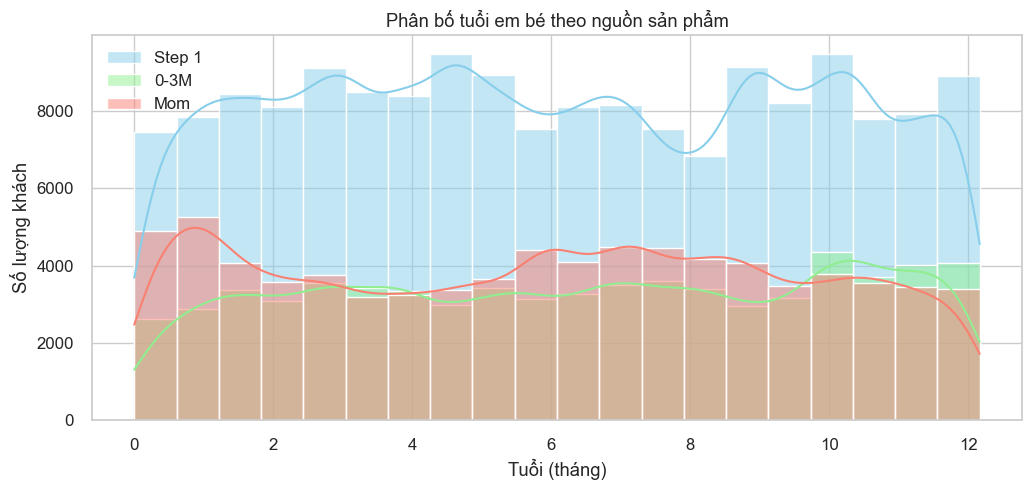

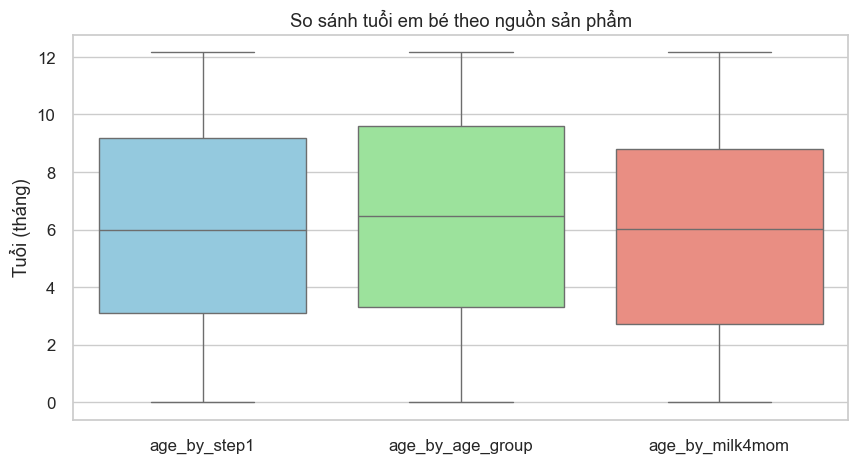

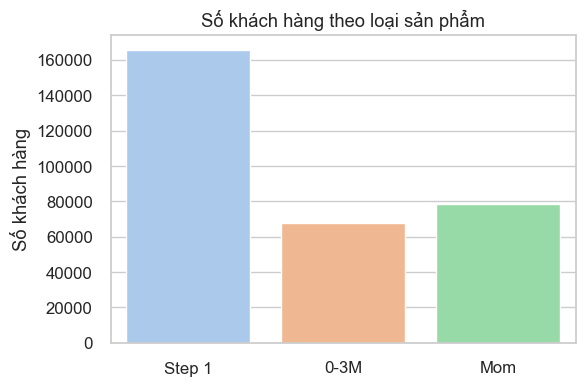

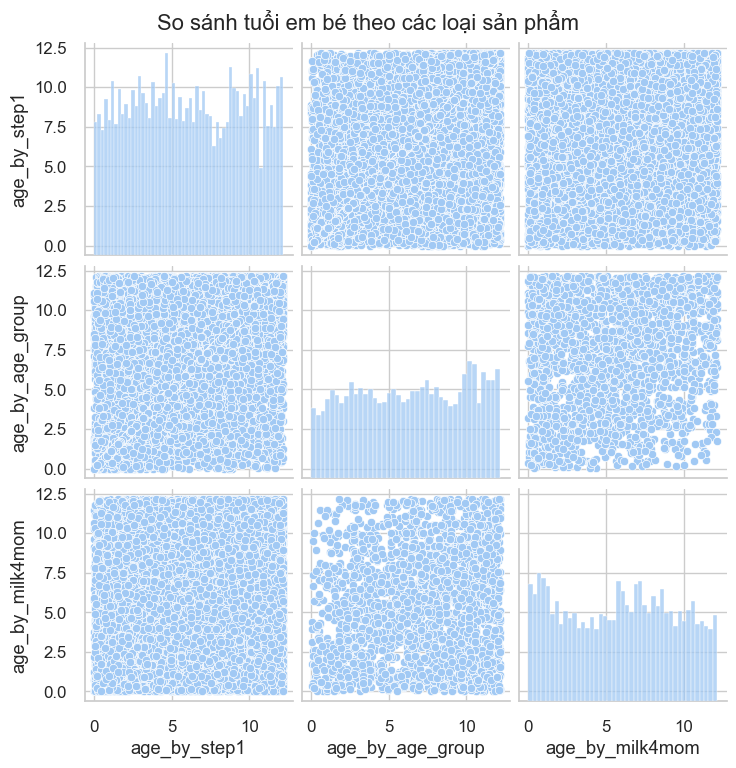

In [16]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Chuyển created_date sang datetime
sales_purchase_df = sales_purchase_df.with_columns(
    pl.col("created_date").cast(pl.Datetime)
)

# Lọc sản phẩm theo tiêu chí
milk_step1 = sales_item_df.filter(
    pl.col("description").str.to_lowercase().str.contains("step 1")
)
milk_mom = sales_item_df.filter(
    pl.col("description").str.to_lowercase().str.contains("mom")
)
milk_age_0_3m = sales_item_df.filter(
    pl.col("age_group").str.to_lowercase().str.contains("0-3m")
)

# Join purchase với các loại sữa
join_cols = ["item_id"]
purchase_step1 = sales_purchase_df.join(milk_step1, on=join_cols, how="inner")
purchase_mom = sales_purchase_df.join(milk_mom, on=join_cols, how="inner")
purchase_age = sales_purchase_df.join(milk_age_0_3m, on=join_cols, how="inner")

# Tính ngày mua đầu tiên / cuối cùng theo customer=
agg_step1 = (
    purchase_step1.group_by("customer_id")
    .agg(pl.col("created_date").min().alias("first_date_buy_step1"))
)

agg_mom = (
    purchase_mom.group_by("customer_id")
    .agg(pl.col("created_date").max().alias("last_date_buy_milk4mom"))
)

agg_age = (
    purchase_age.group_by("customer_id")
    .agg(pl.col("created_date").min().alias("first_date_buy_age_group_0_3M"))
)

# Gộp kết quả
pred_age_df = (
    agg_step1.join(agg_age, on="customer_id", how="outer", suffix="_age")
             .join(agg_mom, on="customer_id", how="outer", suffix="_mom")
)

# Dự đoán tuổi em bé theo tháng
today = sales_purchase_df["created_date"].max()

pred_age_df = pred_age_df.with_columns([
    ((today - pl.col("first_date_buy_step1")).dt.total_days() / 30).alias("age_by_step1"),
    ((today - pl.col("first_date_buy_age_group_0_3M")).dt.total_days() / 30).alias("age_by_age_group"),
    ((today - pl.col("last_date_buy_milk4mom")).dt.total_days() / 30).alias("age_by_milk4mom"),
])

# Chuyển sang Pandas để vẽ biểu đồ
df_plot = pred_age_df.select([
    "age_by_step1", "age_by_age_group", "age_by_milk4mom"
]).to_pandas()

# Vẽ histogram phân bố tuổi
plt.figure(figsize=(12,5))
sns.histplot(df_plot['age_by_step1'].dropna(), bins=20, kde=True, color='skyblue', label='Step 1')
sns.histplot(df_plot['age_by_age_group'].dropna(), bins=20, kde=True, color='lightgreen', label='0-3M')
sns.histplot(df_plot['age_by_milk4mom'].dropna(), bins=20, kde=True, color='salmon', label='Mom')
plt.title("Phân bố tuổi em bé theo nguồn sản phẩm")
plt.xlabel("Tuổi (tháng)")
plt.ylabel("Số lượng khách")
plt.legend()
plt.show()

# Vẽ boxplot so sánh tuổi
plt.figure(figsize=(10,5))
sns.boxplot(data=df_plot, palette=["skyblue","lightgreen","salmon"])
plt.title("So sánh tuổi em bé theo nguồn sản phẩm")
plt.ylabel("Tuổi (tháng)")
plt.show()

# Vẽ bar chart số khách theo loại sản phẩm
counts = {
    "Step 1": df_plot['age_by_step1'].dropna().shape[0],
    "0-3M": df_plot['age_by_age_group'].dropna().shape[0],
    "Mom": df_plot['age_by_milk4mom'].dropna().shape[0]
}

plt.figure(figsize=(6,4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="pastel")
plt.title("Số khách hàng theo loại sản phẩm")
plt.ylabel("Số khách hàng")
plt.show()

# Scatter plot so sánh các nguồn tuổi
sns.pairplot(df_plot)
plt.suptitle("So sánh tuổi em bé theo các loại sản phẩm", y=1.02)
plt.show()